In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sb
sb.set()
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [2]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Data Preparation

In [3]:
parsed_data=pd.read_csv('/Users/Klaus/OneDrive - Nanyang Technological University/Desktop/SC1015 Intro to Data Science & AI/MINI PROJECT FILES/Files/parsed_data.csv')
parsed_data=parsed_data.fillna(0)

In [4]:
upperoutlier = pd.DataFrame(parsed_data['Outliers'])

upperoutlier.value_counts()

Outliers
0           70648
1            2875
dtype: int64

This shows that a total of 2875 data rows were marked as outlier data from our clustering model.

# Models

## 1) We will first be analysing the best colour to predict a shoe being sold at an unorthodox price for the highest earnings.

### Using decision trees,

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9683260226461288

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9679700782046923



<AxesSubplot:>

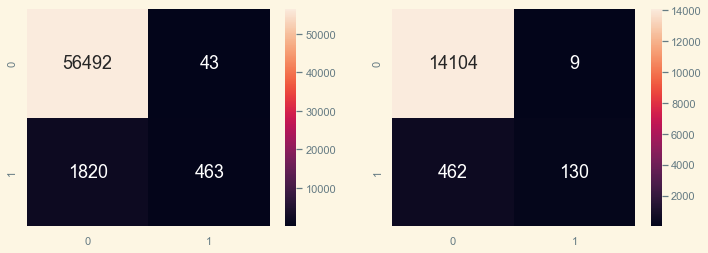

In [5]:
predictors = pd.DataFrame(parsed_data[["Black","White","Grey","Red","Green","Neo","Orange","Tan/Brown","Pink","Blue","Colorful"]])     # Predictor

#Splitting dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(predictors, upperoutlier, test_size = 0.20)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  #Starting assumption of depth 3
dectree.fit(X_train, y_train)                  

# Predict whether data are outliers according to trained model
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We notice that the data seems to have a bias in predicting the data as non-outliers. This is due to a huge imbalance in our dataset due to the higher proportion of 1s than 0s as seen below.

In [6]:
y_train.value_counts()

Outliers
0           56535
1            2283
dtype: int64

## Thus, we will make use of a combination of SMOTE oversampling and Edited Nearest Neighbors undersampling to create a less unbalanced dataset.

In [7]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
#from imblearn.under_sampling import TomekLinks

sm = SMOTEENN(random_state = 2,enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [8]:
y_train_smote.value_counts()

Outliers
1           56535
0           52184
dtype: int64

As we can see, the data is now less unbalanced between 0s and 1s, which enables us to get a fairer classification.

In [9]:
dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree.fit(X_train_smote, y_train_smote) # train the decision tree model

y_train_pred = dectree.predict(X_train_smote)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train_smote, y_train_smote))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8651845583568649

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6961577694661679



### Using K-Fold Cross Validation, where the dataset is randomly split into multiple independent train and test datasets and the accuracy of all predictions are averaged (k=10 folds), we use it to test the accuracy of the current model on the whole dataset.

In [10]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=10, random_state=1,shuffle=True)

scores = cross_val_score(dectree,predictors, upperoutlier, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Model Dataset Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Dataset Accuracy: 0.968 (0.001)


<AxesSubplot:>

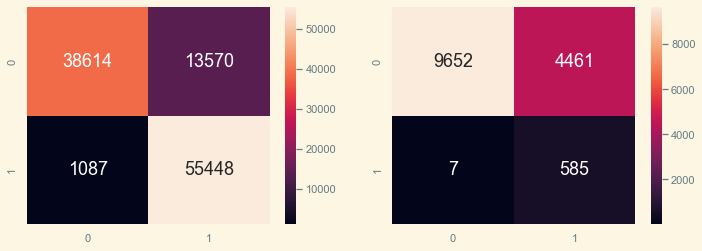

In [11]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_smote, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We can see a substantial increase in the model predicting the shoe as an outlier compared to before.

In the test dataset however, not many are still predicted as outliers which is to be expected as these profitable shoes are not supposed to be easy to come by.


### However, since the train data accuracy is higher than the test data accuracy, there could be a case of overfitting. We will now make use of pruning techniques to allow the model to be able to better fit test data and have higher accuracy.

## Using Cost Complexity Pruning,

In [12]:
path = dectree.cost_complexity_pruning_path(X_train_smote,y_train_smote)
alphas = path['ccp_alphas']

alphas

array([0.        , 0.00053118, 0.00950242, 0.01958819, 0.04256948,
       0.06074925, 0.0717287 , 0.09878658])

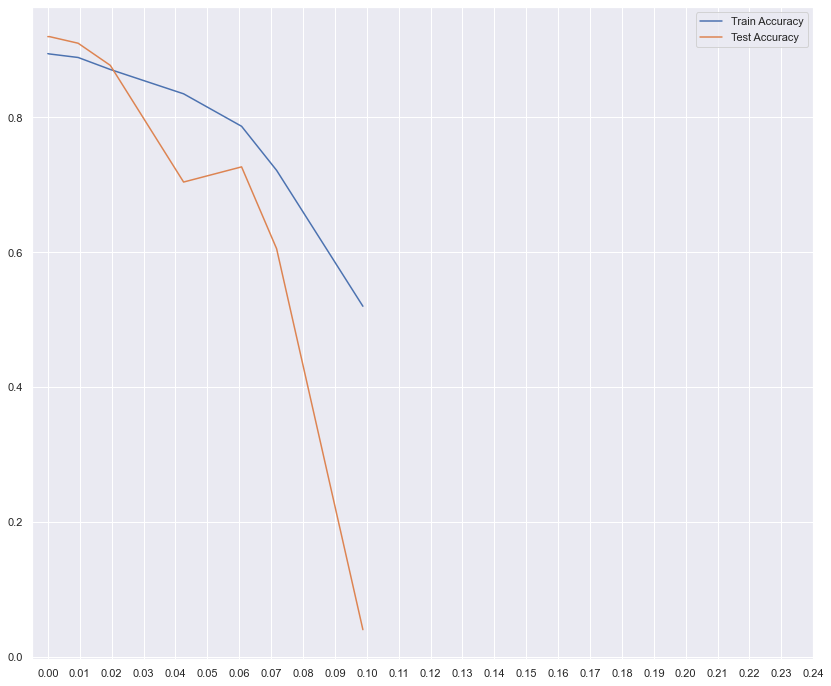

In [13]:
from sklearn.metrics import accuracy_score
accuracy_train, accuracy_test=[],[]

for i in alphas:
    dectree=DecisionTreeClassifier(ccp_alpha=i)
    
    dectree.fit(X_train_smote,y_train_smote)
    y_train_pred=dectree.predict(X_train_smote)
    y_test_pred=dectree.predict(X_test)
    
    accuracy_train.append(accuracy_score(y_train_smote,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    
sb.set()
plt.figure(figsize=(14,12))
sb.lineplot(y=accuracy_train,x=alphas,label="Train Accuracy")
sb.lineplot(y=accuracy_test,x=alphas,label="Test Accuracy")
plt.xticks(ticks=np.arange(0.00,0.25,0.01))
plt.show()

Using the graph above (plotting the accuracy of predicting train and test datasests against alpha values), we can see that there is an intersection in the accuracy values of the train and test dataset predicted using the model.

To minimise the difference in accuracies of the 2 models, we want to use an alpha value (x-axis) in our tree at a point the 2 graphs are close to intersect but not too low of alpha value.Also, we would want the test accuracy to be high where possible. Thus, I will be using an alpha value at around the 0.05-0.06 range seen above, which is not too far from the train accuracy.

In [14]:
#Alpha value now set to approximately 0.06
dectree=DecisionTreeClassifier(ccp_alpha=0.062)
dectree.fit(X_train_smote,y_train_smote)
y_train_pred = dectree.predict(X_train_smote)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train_smote, y_train_smote))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7869553619882449

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7267596055763346



### Using K-Fold Cross Validation,

In [15]:
cv = StratifiedKFold(n_splits=10, random_state=1,shuffle=True)

scores = cross_val_score(dectree,predictors, upperoutlier, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Model Dataset Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Dataset Accuracy: 0.961 (0.000)


<AxesSubplot:>

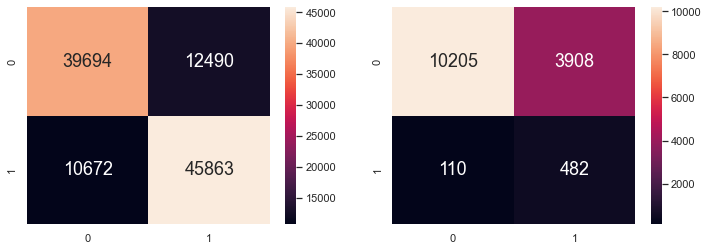

In [16]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_smote, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

As we can see now, there is now, the test data accuracy has increased slightly and we are better able to match the train data accuracy but the K-Folds accuracy has not changed much - some overfitting has been reduced.

## However, since our data was resampled, it could possibly lead to reduced accuracy, thus, we will be using the balanced random forest classification on the unsampled data instead which eliminates class imbalances through iteratively drawing a bootstrap sample with equal proportions of data points from both the minority and the majority class.

## Balanced Random Forest Classification:

In [17]:
from imblearn.ensemble import BalancedRandomForestClassifier
rf = BalancedRandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 3)
rf.fit(X_train, y_train.values.ravel())
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [18]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model: Train Dataset")
print('Train Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model: Test Dataset")
print('Test Model accuracy score:  {0:0.4f}'. format(accuracy_score(y_test, y_test_pred)))
print()

Goodness of Fit of Model: Train Dataset
Train Model accuracy score: 0.7129

Goodness of Fit of Model: Test Dataset
Test Model accuracy score:  0.7150



### Using K-Fold Cross Validation,

In [19]:
cv = StratifiedKFold(n_splits=10, random_state=1,shuffle=True)

scores = cross_val_score(rf,predictors, upperoutlier, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Model Dataset Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Dataset Accuracy: 0.713 (0.003)


It seems that the balanced forest classifier does not seem to be as accurate in setting up the model, as it uses a random undersampling technique which might not be a great way to sample the data alone.

## Accuracy can be improved. We will attempt conducting Random Forest Classification on the oversampled data instead.

## Random Forest Classifier:

In [20]:
from sklearn.ensemble import RandomForestClassifier

#Use of balanced random forest, might not be necessarily as our data is oversampled
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 3)
rf.fit(X_train_smote, y_train_smote.values.ravel())
y_train_pred = rf.predict(X_train_smote)
y_test_pred = rf.predict(X_test)

In [21]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model: Train Dataset")
print('Train Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train_smote, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model: Test Dataset")
print('Test Model accuracy score:  {0:0.4f}'. format(accuracy_score(y_test, y_test_pred)))
print()

Goodness of Fit of Model: Train Dataset
Train Model accuracy score: 0.8751

Goodness of Fit of Model: Test Dataset
Test Model accuracy score:  0.7150



### Using K-Fold Cross Validation,

In [22]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(rf,predictors, upperoutlier, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Model Dataset Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Dataset Accuracy: 0.968 (0.001)


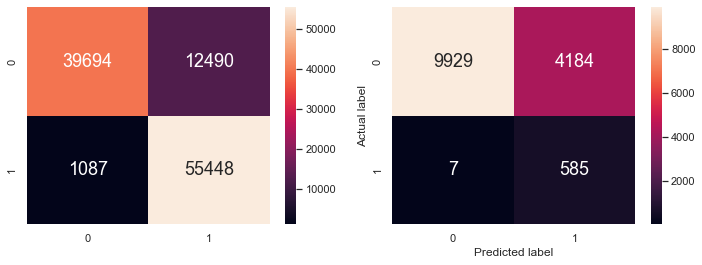

In [23]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_smote, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

### As we can see, there is only a slight change in average accuracy from the balanced decision tree classifier & balanced random forest classifier. However, the K-Fold cross validation score is alot higher at around 96% compared to the 71% of the balanced random forest classifier

#### We will now display the decision tree model using the usual random forest classifier:

[Text(804.8076923076923, 951.3000000000001, 'Grey <= 0.5\ngini = 0.499\nsamples = 68555\nvalue = [52353, 56366]\nclass = Sold unusually high'),
 Text(429.2307692307692, 679.5, 'White <= 0.5\ngini = 0.473\nsamples = 53862\nvalue = [32731, 52615]\nclass = Sold unusually high'),
 Text(214.6153846153846, 407.70000000000005, 'Pink <= 0.5\ngini = 0.378\nsamples = 17015\nvalue = [20176, 6842]\nclass = Not Sold high'),
 Text(107.3076923076923, 135.89999999999998, 'gini = 0.388\nsamples = 16340\nvalue = [19120, 6842]\nclass = Not Sold high'),
 Text(321.9230769230769, 135.89999999999998, 'gini = 0.0\nsamples = 675\nvalue = [1056, 0]\nclass = Not Sold high'),
 Text(643.8461538461538, 407.70000000000005, 'Colorful <= 0.5\ngini = 0.338\nsamples = 36847\nvalue = [12555, 45773]\nclass = Sold unusually high'),
 Text(536.5384615384615, 135.89999999999998, 'gini = 0.435\nsamples = 23062\nvalue = [11679, 24777]\nclass = Sold unusually high'),
 Text(751.1538461538462, 135.89999999999998, 'gini = 0.077\nsa

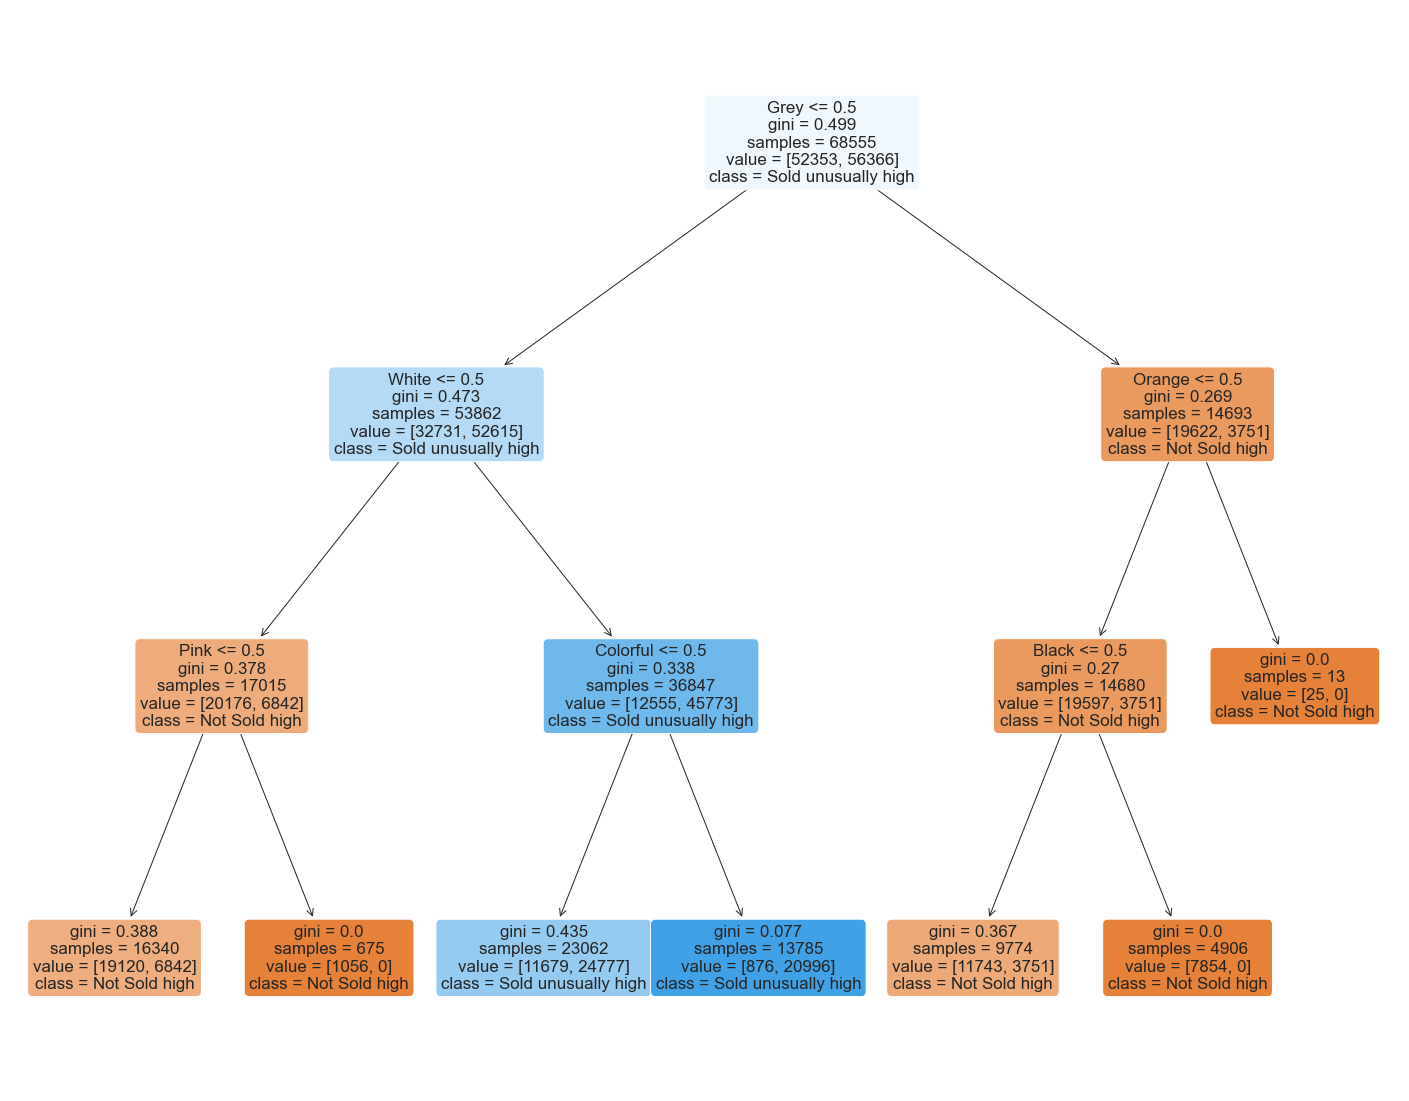

In [24]:
from sklearn.tree import plot_tree

tree_small = rf.estimators_[5]
fig = plt.figure(figsize=(25,20))
plot_tree(tree_small, filled=True, rounded=True,
          feature_names=X_train.columns,
          class_names=["Not Sold high","Sold unusually high"])

We can interpret this tree as, shoes not being grey might be the most important predictor in determining the shoe being one is sold at an anomalous price, followed by shoes being white or the colour not being orange.

As shoes can have a combination of colours, overlapping of such colour predictors are probable.

### Final Analysis using Recursive Feature Elimination (RFE)

In [25]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 3), n_features_to_select=1)
rfe = rfe.fit(X_train_smote, y_train_smote.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False False]
[ 4  1  2  5 11  9  7 10  8  6  3]


In [26]:
print(X_train.columns)

Index(['Black', 'White', 'Grey', 'Red', 'Green', 'Neo', 'Orange', 'Tan/Brown',
       'Pink', 'Blue', 'Colorful'],
      dtype='object')


The RFE algorithm assuming minimal overfitting seems to give the factor of a shoe being white or not as the most important factor, as seen in the rankings above.

## Using the XGBoost Classifier (Gradient Boosting):

In [27]:
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier(max_depth=3)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.03167	validation_0-logloss:0.46806	validation_1-error:0.03203	validation_1-logloss:0.46825
[1]	validation_0-error:0.03167	validation_0-logloss:0.34271	validation_1-error:0.03203	validation_1-logloss:0.34260
[2]	validation_0-error:0.03167	validation_0-logloss:0.26718	validation_1-error:0.03203	validation_1-logloss:0.26724
[3]	validation_0-error:0.03167	validation_0-logloss:0.21621	validation_1-error:0.03203	validation_1-logloss:0.21591
[4]	validation_0-error:0.03167	validation_0-logloss:0.17635	validation_1-error:0.03203	validation_1-logloss:0.17587
[5]	validation_0-error:0.03167	validation_0-logloss:0.15423	validation_1-error:0.03203	validation_1-logloss:0.15382
[6]	validation_0-error:0.03167	validation_0-logloss:0.13489	validation_1-error:0.03203	validation_1-logloss:0.13405
[7]	validation_0-error:0.03167	validation_0-logloss:0.12259	validation_1-error:0.03203	validation_1-logloss:0.12154
[8]	validation_0-error:0.03167	validation_0-logloss:0.11392	validation_1

C:\Users\Klaus\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-error:0.03076	validation_0-logloss:0.08922	validation_1-error:0.03108	validation_1-logloss:0.08734
[20]	validation_0-error:0.03076	validation_0-logloss:0.08884	validation_1-error:0.03108	validation_1-logloss:0.08683
[21]	validation_0-error:0.03076	validation_0-logloss:0.08783	validation_1-error:0.03108	validation_1-logloss:0.08567
[22]	validation_0-error:0.03076	validation_0-logloss:0.08696	validation_1-error:0.03108	validation_1-logloss:0.08460
[23]	validation_0-error:0.03076	validation_0-logloss:0.08686	validation_1-error:0.03108	validation_1-logloss:0.08449
[24]	validation_0-error:0.03076	validation_0-logloss:0.08669	validation_1-error:0.03108	validation_1-logloss:0.08423
[25]	validation_0-error:0.03076	validation_0-logloss:0.08633	validation_1-error:0.03108	validation_1-logloss:0.08378
[26]	validation_0-error:0.03076	validation_0-logloss:0.08623	validation_1-error:0.03108	validation_1-logloss:0.08367
[27]	validation_0-error:0.03076	validation_0-logloss:0.08589	val

[89]	validation_0-error:0.02999	validation_0-logloss:0.08504	validation_1-error:0.02849	validation_1-logloss:0.08226
[90]	validation_0-error:0.02999	validation_0-logloss:0.08504	validation_1-error:0.02849	validation_1-logloss:0.08226
[91]	validation_0-error:0.02999	validation_0-logloss:0.08504	validation_1-error:0.02849	validation_1-logloss:0.08227
[92]	validation_0-error:0.02999	validation_0-logloss:0.08504	validation_1-error:0.02849	validation_1-logloss:0.08227
[93]	validation_0-error:0.02999	validation_0-logloss:0.08503	validation_1-error:0.02849	validation_1-logloss:0.08226
[94]	validation_0-error:0.02999	validation_0-logloss:0.08503	validation_1-error:0.02849	validation_1-logloss:0.08226
[95]	validation_0-error:0.02999	validation_0-logloss:0.08503	validation_1-error:0.02849	validation_1-logloss:0.08226
[96]	validation_0-error:0.02999	validation_0-logloss:0.08503	validation_1-error:0.02849	validation_1-logloss:0.08226
[97]	validation_0-error:0.02999	validation_0-logloss:0.08503	val

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
predictions_train = [round(value) for value in y_pred_train]
predictions_test = [round(value) for value in y_pred_test]
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Train Accuracy: 97.00%
Test Accuracy: 97.15%


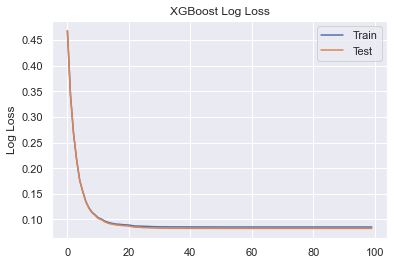

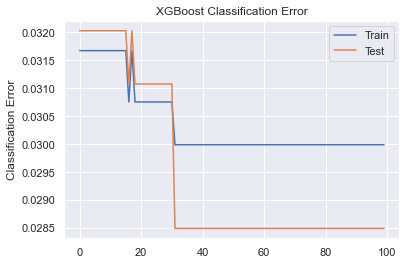

In [29]:
from numpy import loadtxt
from matplotlib import pyplot

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### The model might have overfitted and subject to class imbalance as the train and test accuracy is really high, and the classification error plot comes to a constant line after epoch = 30 approximately. 

### We need to introduce early stopping at the correct epoch to ensure that there is no overfitting while maintaining a sufficient test accuracy.

### Also, an implementation of weighted classifying due to the large imbalance in our dataset.

### Total training epochs as observed in model print = 99

In [30]:
c

Outliers
0           56535
1            2283
dtype: int64

A reliable way of determining the weight scaling of the XGB Classifier is by taking the ratio of the class imbalance = 56484/2334 which is approximately 24.35.

In [31]:
# fit model no training data
model = XGBClassifier(max_depth=3, scale_pos_weight=24.35)
model.fit(X_train, y_train,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

print(model)

[0]	validation_0-error:0.28711	validation_0-logloss:0.55945	validation_1-error:0.28501	validation_1-logloss:0.55855
[1]	validation_0-error:0.28711	validation_0-logloss:0.49319	validation_1-error:0.28501	validation_1-logloss:0.49138
[2]	validation_0-error:0.28711	validation_0-logloss:0.45229	validation_1-error:0.28501	validation_1-logloss:0.44994
[3]	validation_0-error:0.27254	validation_0-logloss:0.40477	validation_1-error:0.27100	validation_1-logloss:0.40189
[4]	validation_0-error:0.27254	validation_0-logloss:0.38656	validation_1-error:0.27100	validation_1-logloss:0.38382
[5]	validation_0-error:0.27254	validation_0-logloss:0.36002	validation_1-error:0.27100	validation_1-logloss:0.35669
[6]	validation_0-error:0.27254	validation_0-logloss:0.35224	validation_1-error:0.27100	validation_1-logloss:0.34905
[7]	validation_0-error:0.27254	validation_0-logloss:0.34105	validation_1-error:0.27100	validation_1-logloss:0.33736
[8]	validation_0-error:0.27254	validation_0-logloss:0.33466	validation_1

C:\Users\Klaus\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-error:0.08185	validation_0-logloss:0.30145	validation_1-error:0.08004	validation_1-logloss:0.29609
[20]	validation_0-error:0.08185	validation_0-logloss:0.30023	validation_1-error:0.08004	validation_1-logloss:0.29464
[21]	validation_0-error:0.08185	validation_0-logloss:0.30010	validation_1-error:0.08004	validation_1-logloss:0.29452
[22]	validation_0-error:0.08185	validation_0-logloss:0.29980	validation_1-error:0.08004	validation_1-logloss:0.29413
[23]	validation_0-error:0.08185	validation_0-logloss:0.29913	validation_1-error:0.08004	validation_1-logloss:0.29332
[24]	validation_0-error:0.08185	validation_0-logloss:0.29829	validation_1-error:0.08004	validation_1-logloss:0.29243
[25]	validation_0-error:0.08185	validation_0-logloss:0.29814	validation_1-error:0.08004	validation_1-logloss:0.29221
[26]	validation_0-error:0.08185	validation_0-logloss:0.29804	validation_1-error:0.08004	validation_1-logloss:0.29213
[27]	validation_0-error:0.08185	validation_0-logloss:0.29762	val

[90]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28814
[91]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28814
[92]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28814
[93]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28814
[94]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28814
[95]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28813
[96]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28813
[97]	validation_0-error:0.08185	validation_0-logloss:0.29476	validation_1-error:0.08004	validation_1-logloss:0.28813
[98]	validation_0-error:0.08185	validation_0-logloss:0.29477	val

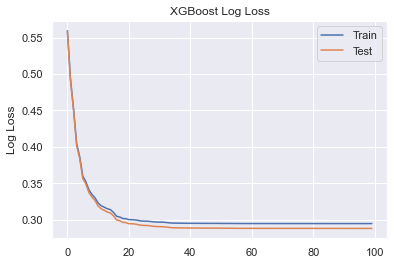

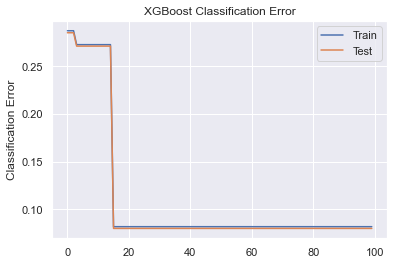

In [32]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

By observation of the model print above and the classification error graph, the datasets seem to produce its latest minimal validation error at epoch = 16 where validation_0-error:0.08173, validation_1-error:0.08052

### Thus, making use of early stopping of the XGBoost model:

In [33]:
model = XGBClassifier(scale_pos_weight=24.35, early_stopping_rounds=10,max_depth=3)
model.fit(X_train, y_train,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

print(model)

[0]	validation_0-error:0.28711	validation_0-logloss:0.55945	validation_1-error:0.28501	validation_1-logloss:0.55855
[1]	validation_0-error:0.28711	validation_0-logloss:0.49319	validation_1-error:0.28501	validation_1-logloss:0.49138
[2]	validation_0-error:0.28711	validation_0-logloss:0.45229	validation_1-error:0.28501	validation_1-logloss:0.44994
[3]	validation_0-error:0.27254	validation_0-logloss:0.40477	validation_1-error:0.27100	validation_1-logloss:0.40189
[4]	validation_0-error:0.27254	validation_0-logloss:0.38656	validation_1-error:0.27100	validation_1-logloss:0.38382
[5]	validation_0-error:0.27254	validation_0-logloss:0.36002	validation_1-error:0.27100	validation_1-logloss:0.35669
[6]	validation_0-error:0.27254	validation_0-logloss:0.35224	validation_1-error:0.27100	validation_1-logloss:0.34905
[7]	validation_0-error:0.27254	validation_0-logloss:0.34105	validation_1-error:0.27100	validation_1-logloss:0.33736
[8]	validation_0-error:0.27254	validation_0-logloss:0.33466	validation_1

[71]	validation_0-error:0.08185	validation_0-logloss:0.29479	validation_1-error:0.08004	validation_1-logloss:0.28820
[72]	validation_0-error:0.08185	validation_0-logloss:0.29479	validation_1-error:0.08004	validation_1-logloss:0.28819
[73]	validation_0-error:0.08185	validation_0-logloss:0.29479	validation_1-error:0.08004	validation_1-logloss:0.28819
[74]	validation_0-error:0.08185	validation_0-logloss:0.29479	validation_1-error:0.08004	validation_1-logloss:0.28819
[75]	validation_0-error:0.08185	validation_0-logloss:0.29479	validation_1-error:0.08004	validation_1-logloss:0.28819
[76]	validation_0-error:0.08185	validation_0-logloss:0.29479	validation_1-error:0.08004	validation_1-logloss:0.28819
[77]	validation_0-error:0.08185	validation_0-logloss:0.29478	validation_1-error:0.08004	validation_1-logloss:0.28819
[78]	validation_0-error:0.08185	validation_0-logloss:0.29478	validation_1-error:0.08004	validation_1-logloss:0.28819
[79]	validation_0-error:0.08185	validation_0-logloss:0.29479	val

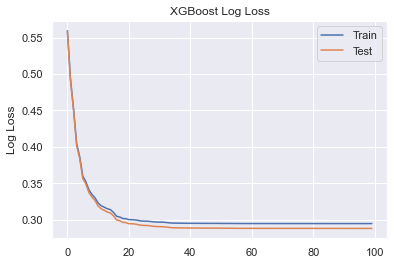

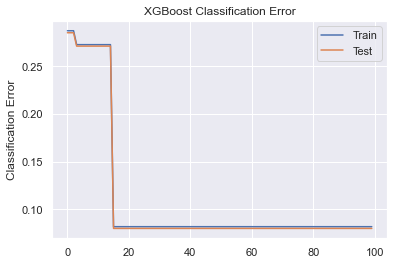

In [34]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [35]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
predictions_train = [round(value) for value in y_pred_train]
predictions_test = [round(value) for value in y_pred_test]
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Train Accuracy: 91.82%
Test Accuracy: 92.00%


In [37]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     14113
           1       0.31      0.82      0.45       592

    accuracy                           0.92     14705
   macro avg       0.65      0.87      0.70     14705
weighted avg       0.96      0.92      0.94     14705



<AxesSubplot:>

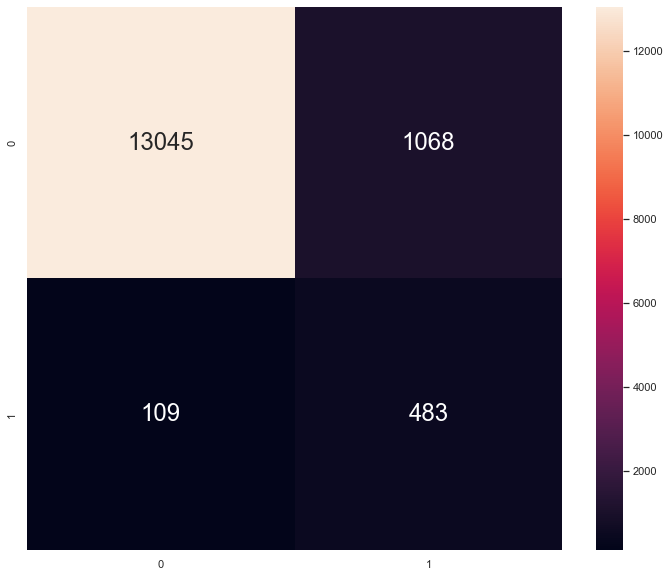

In [38]:
f, axes = plt.subplots(1, figsize=(12, 10))
sb.heatmap(metrics.confusion_matrix(y_test, y_pred_test),
           annot = True, fmt=".0f", annot_kws={"size": 24})

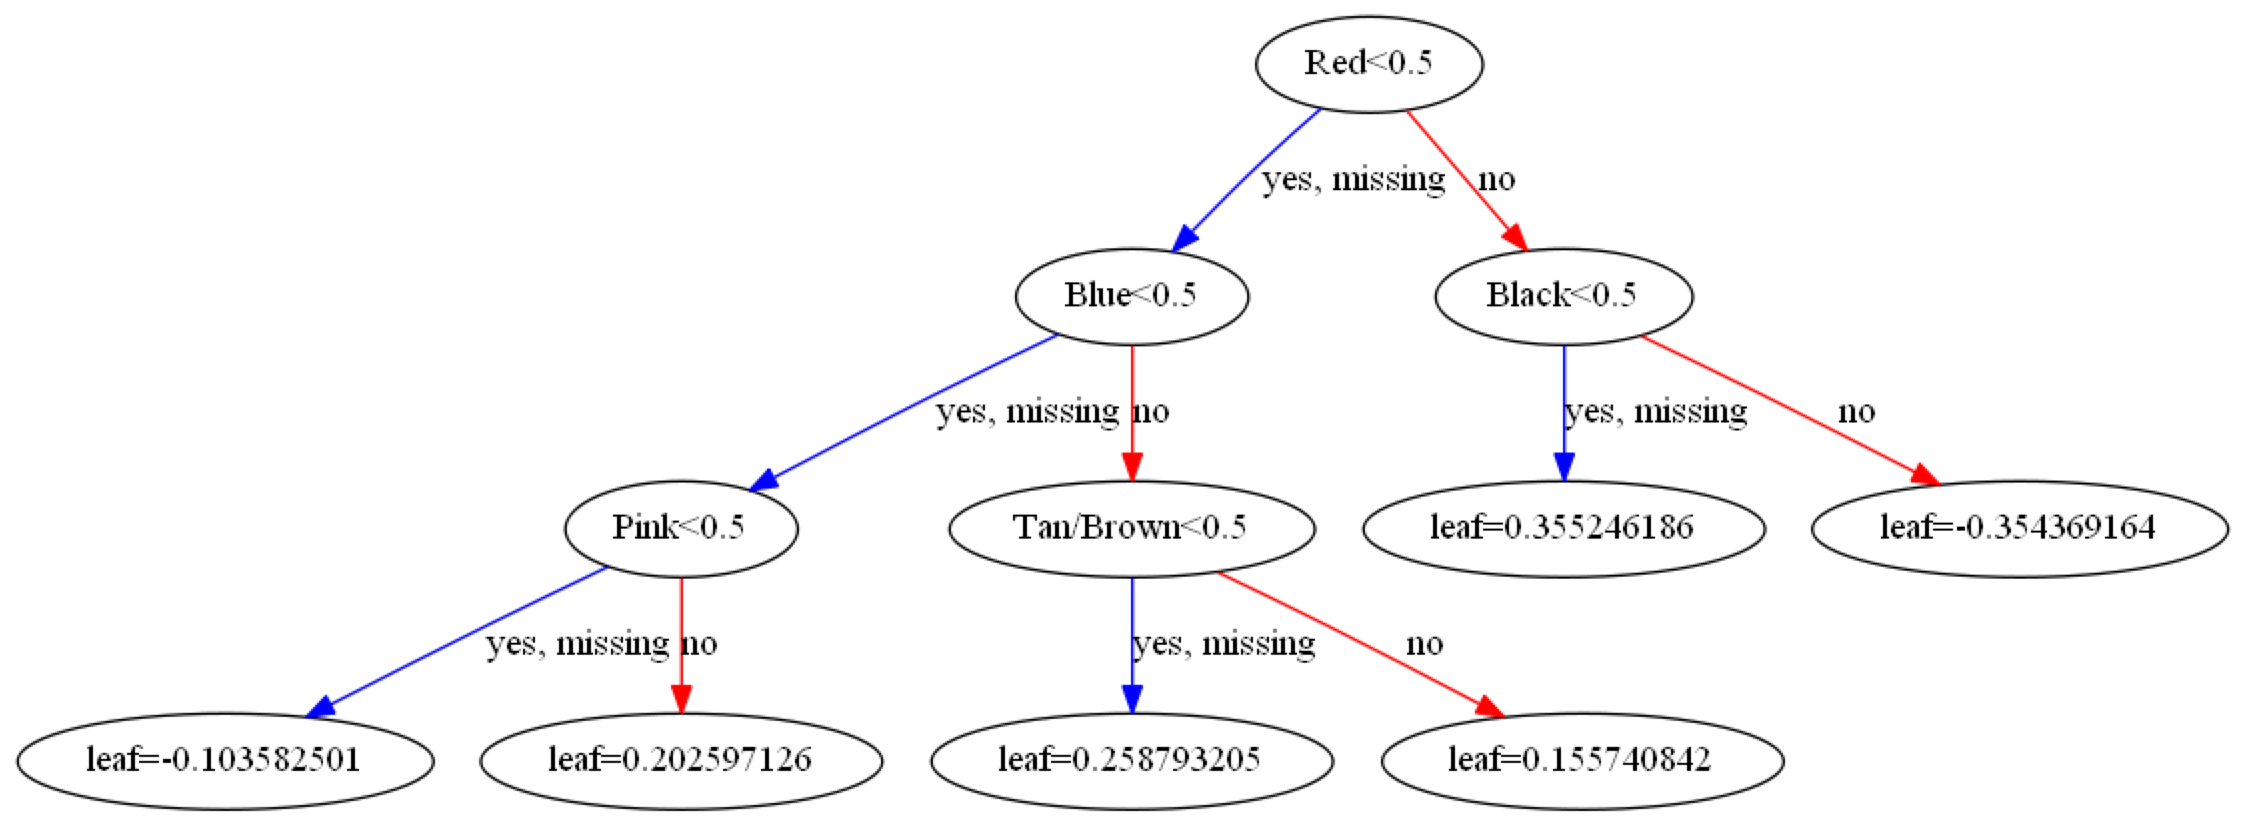

In [39]:
from xgboost import plot_tree
import graphviz
fig, ax = plt.subplots(figsize=(40, 40))
plot_tree(model, num_trees=4, ax=ax)
plt.show()

This model seems to show a shoe not being red as the most important predictor.

# Can a regression model be used to predict the trends in finding these outliers?

In [64]:
from sklearn.linear_model import LogisticRegression
w = {0:56498, 1:2320}
clf = LogisticRegression(random_state=30,solver='lbfgs', max_iter=1000,class_weight=w).fit(X_train, y_train.values.ravel())
y_train_pred=clf.predict(X_train)

In [41]:
print('Accuracy of logistic regression classifier on train set: ')
clf.score(X_train, y_train)

Accuracy of logistic regression classifier on train set: 


0.9611853514230337

In [42]:
from sklearn import metrics
y_test_pred=clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)

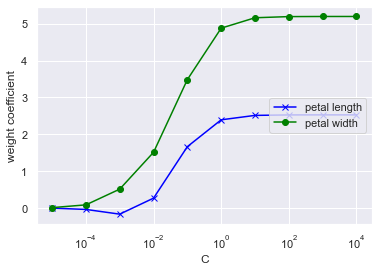

In [44]:
weights, params = [], []
for c in np.arange(-5, 5).astype(float):
   lr = LogisticRegression(C=10**c, random_state=0)
   lr.fit(X_train, y_train.values.ravel())
   weights.append(lr.coef_[0])
   params.append(10**c)

weights = np.array(weights)

plt.plot(params, weights[:, 0], color='blue', marker='x', label='petal length')
plt.plot(params, weights[:, 1], color='green',  marker='o', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='right')
plt.xscale('log')
plt.show()

In [60]:
clf = LogisticRegression(C=10**(-4),random_state=30,solver='lbfgs', max_iter=1000,class_weight=w).fit(X_train, y_train.values.ravel())
y_train_pred=clf.predict(X_train)

In [61]:
print('Accuracy of logistic regression classifier on train set: ')
clf.score(X_train, y_train)

Accuracy of logistic regression classifier on train set: 


0.9611905787409607

In [62]:
y_test_pred=clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)

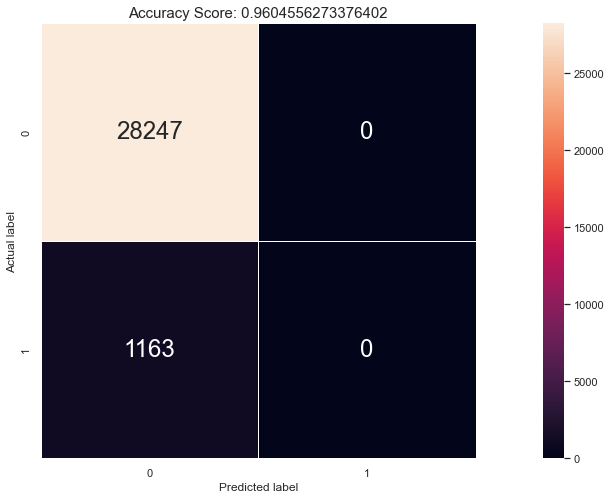

In [63]:
f, axes = plt.subplots(1, figsize=(24, 8))
sb.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,annot_kws={"size": 24});
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(clf.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

Logistic regression makes predictions based on probabilities and might not be a very good fit for our dataset which has a huge class imbalance.

# Now, we will use the shoe size as a predictor instead:

### Data Preparation:

In [82]:
predictors = pd.DataFrame(parsed_data[["Shoe Size"]])     # Predictor
predictors["Shoe Size"].astype(float)

#Splitting dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(predictors, upperoutlier, test_size = 0.20)

In [81]:
y_train.value_counts()

Outliers
0           56518
1            2300
dtype: int64

### SMOTEENN sampling:

In [86]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
sm = SMOTEENN(random_state = 12)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [87]:
y_train_smote.value_counts()

Outliers
0           14783
1           13942
dtype: int64

### Decision Tree Default & Pruning:

In [95]:
dectree=DecisionTreeClassifier(max_depth = 3)
dectree.fit(X_train_smote,y_train_smote)
y_train_pred = dectree.predict(X_train_smote)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train_smote, y_train_smote))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9974238468233246

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6100646038762326



In [89]:
path = dectree.cost_complexity_pruning_path(X_train_smote,y_train_smote)
alphas = path['ccp_alphas']

alphas

array([0.00000000e+00, 2.46138062e-05, 1.82792661e-04, 3.90530827e-03,
       2.45269873e-01])

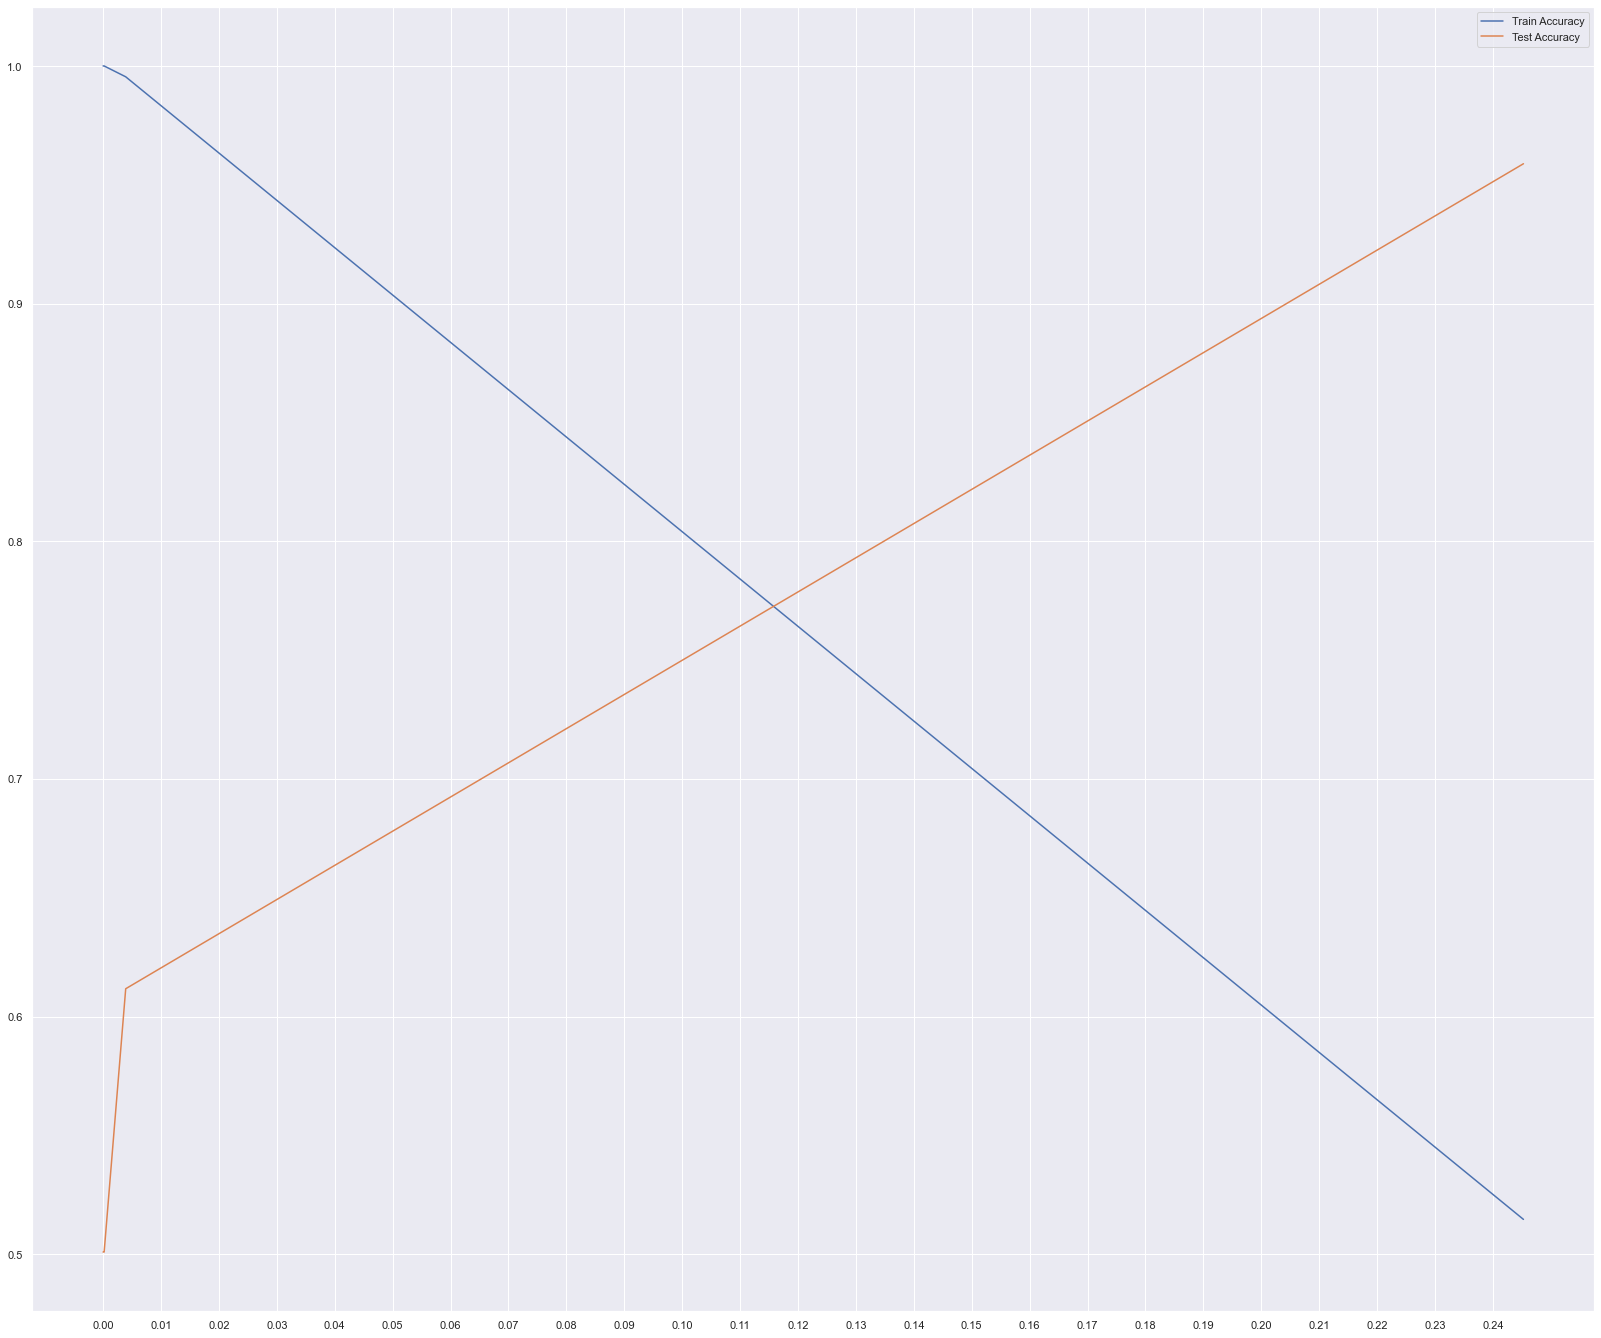

In [93]:
from sklearn.metrics import accuracy_score
accuracy_train, accuracy_test=[],[]

for i in alphas:
    dectree=DecisionTreeClassifier(ccp_alpha= i)
    
    dectree.fit(X_train_smote,y_train_smote)
    y_train_pred=dectree.predict(X_train_smote)
    y_test_pred=dectree.predict(X_test)
    
    accuracy_train.append(accuracy_score(y_train_smote,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    
sb.set()
plt.figure(figsize=(28,24))
sb.lineplot(y=accuracy_train,x=alphas,label="Train Accuracy")
sb.lineplot(y=accuracy_test,x=alphas,label="Test Accuracy")
plt.xticks(ticks=np.arange(0.00,0.25,0.01))
plt.show()

In [96]:
#Alpha value now set to approximately 0.03
dectree=DecisionTreeClassifier(ccp_alpha=0.1)
dectree.fit(X_train_smote,y_train_smote)
y_train_pred = dectree.predict(X_train_smote)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train_smote, y_train_smote))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9954395126196692

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6116967018021081



In [97]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(dectree,predictors, upperoutlier, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Model Dataset Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Dataset Accuracy: 0.961 (0.000)


Not a huge improvement in model accuracy. However, Stratified K-Folds Cross Validation returns a favourable accuracy.

<AxesSubplot:>

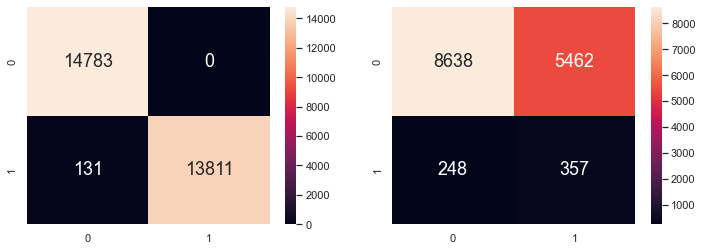

In [98]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_smote, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Using Random Forest Classifier on sampled data:

In [99]:
#Use of balanced random forest, might not be necessarily as our data is oversampled
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 3)
rf.fit(X_train_smote, y_train_smote.values.ravel())
y_train_pred = rf.predict(X_train_smote)
y_test_pred = rf.predict(X_test)

In [100]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model: Train Dataset")
print('Train Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train_smote, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model: Test Dataset")
print('Test Model accuracy score:  {0:0.4f}'. format(accuracy_score(y_test, y_test_pred)))
print()

Goodness of Fit of Model: Train Dataset
Train Model accuracy score: 0.9974

Goodness of Fit of Model: Test Dataset
Test Model accuracy score:  0.6101



In [102]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(rf,predictors, upperoutlier, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Model Dataset Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Dataset Accuracy: 0.961 (0.000)


Accuracy seems to be equally high.

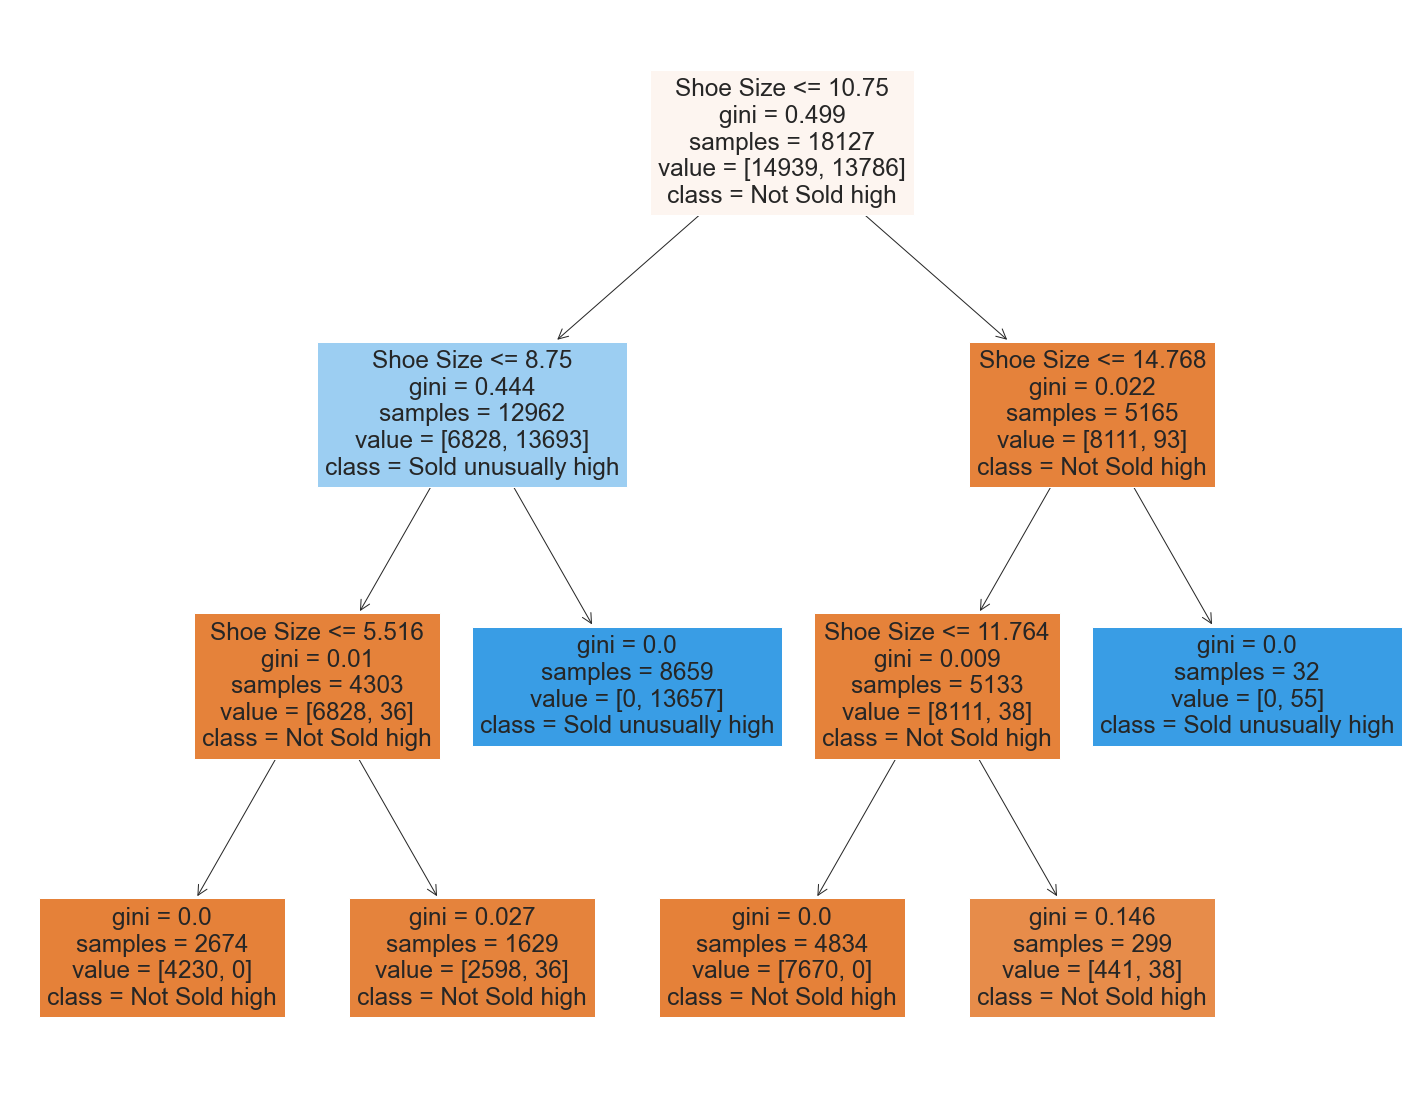

In [103]:
from sklearn import tree

tree_small = rf.estimators_[5]
fig = plt.figure(figsize=(25,20))
fig = tree.plot_tree(tree_small, 
                   feature_names=X_train.columns,  
                   class_names=["Not Sold high","Sold unusually high"],
                   filled=True)

Shoe Sizes <=10.75 seems to be the most important factor for this model in predicting whether it is an outlier.

### XGBoost Classifier:

In [114]:
y_train.value_counts()

Outliers
0           56548
1            2270
dtype: int64

Scale_pos_weight = 56548/2270 = approximately 24.91.

In [129]:
# fit model no training data
model = XGBClassifier(max_depth=3, scale_pos_weight=24.91)
model.fit(X_train, y_train,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

print(model)

[0]	validation_0-error:0.30900	validation_0-logloss:0.67169	validation_1-error:0.30915	validation_1-logloss:0.67187
[1]	validation_0-error:0.30900	validation_0-logloss:0.66134	validation_1-error:0.30915	validation_1-logloss:0.66165
[2]	validation_0-error:0.30900	validation_0-logloss:0.65611	validation_1-error:0.30915	validation_1-logloss:0.65648
[3]	validation_0-error:0.30900	validation_0-logloss:0.65342	validation_1-error:0.30915	validation_1-logloss:0.65386
[4]	validation_0-error:0.30900	validation_0-logloss:0.65191	validation_1-error:0.30915	validation_1-logloss:0.65242
[5]	validation_0-error:0.30900	validation_0-logloss:0.65075	validation_1-error:0.30915	validation_1-logloss:0.65150
[6]	validation_0-error:0.30900	validation_0-logloss:0.65008	validation_1-error:0.30915	validation_1-logloss:0.65090
[7]	validation_0-error:0.30900	validation_0-logloss:0.64953	validation_1-error:0.30915	validation_1-logloss:0.65053
[8]	validation_0-error:0.30900	validation_0-logloss:0.64916	validation_1

[71]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64839
[72]	validation_0-error:0.35651	validation_0-logloss:0.64677	validation_1-error:0.35797	validation_1-logloss:0.64840
[73]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64840
[74]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64840
[75]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64840
[76]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64840
[77]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64840
[78]	validation_0-error:0.35651	validation_0-logloss:0.64676	validation_1-error:0.35797	validation_1-logloss:0.64840
[79]	validation_0-error:0.35651	validation_0-logloss:0.64676	val

In [130]:
# make predictions for test data
y_pred_train = model.predict(X_train_smote)
y_pred_test = model.predict(X_test)
predictions_train = [round(value) for value in y_pred_train]
predictions_test = [round(value) for value in y_pred_test]
# evaluate predictions
accuracy = accuracy_score(y_train_smote, predictions_train)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Train Accuracy: 90.98%
Test Accuracy: 64.20%


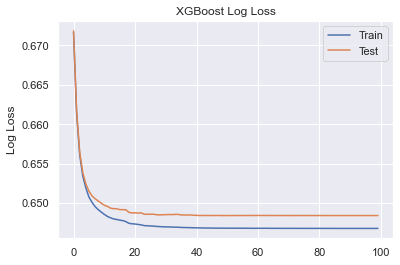

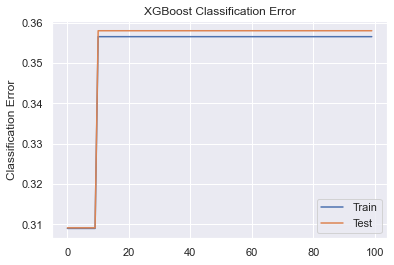

In [131]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

There seems to be some degree of overfitting since test accuracy is alot lower than the train dataset accuracy. We will need to make use of early stopping here too.

In [115]:
model = XGBClassifier(scale_pos_weight=24.91, early_stopping_rounds=10,max_depth=3)
model.fit(X_train, y_train,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

print(model)

[0]	validation_0-error:0.30900	validation_0-logloss:0.67169	validation_1-error:0.30915	validation_1-logloss:0.67187
[1]	validation_0-error:0.30900	validation_0-logloss:0.66134	validation_1-error:0.30915	validation_1-logloss:0.66165
[2]	validation_0-error:0.30900	validation_0-logloss:0.65611	validation_1-error:0.30915	validation_1-logloss:0.65648
[3]	validation_0-error:0.30900	validation_0-logloss:0.65342	validation_1-error:0.30915	validation_1-logloss:0.65386
[4]	validation_0-error:0.30900	validation_0-logloss:0.65191	validation_1-error:0.30915	validation_1-logloss:0.65242
[5]	validation_0-error:0.30900	validation_0-logloss:0.65075	validation_1-error:0.30915	validation_1-logloss:0.65150
[6]	validation_0-error:0.30900	validation_0-logloss:0.65008	validation_1-error:0.30915	validation_1-logloss:0.65090
[7]	validation_0-error:0.30900	validation_0-logloss:0.64953	validation_1-error:0.30915	validation_1-logloss:0.65053
[8]	validation_0-error:0.30900	validation_0-logloss:0.64916	validation_1

In [118]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
predictions_train = [round(value) for value in y_pred_train]
predictions_test = [round(value) for value in y_pred_test]
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Train Accuracy: 64.35%
Test Accuracy: 64.20%


Although test accuracy has not changed much, there seems to be a slightly lesser degree of overfitting as the differences in accuracy are not as huge.

In [119]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.64      0.78     14100
           1       0.07      0.59      0.12       605

    accuracy                           0.64     14705
   macro avg       0.52      0.62      0.45     14705
weighted avg       0.94      0.64      0.75     14705



<AxesSubplot:>

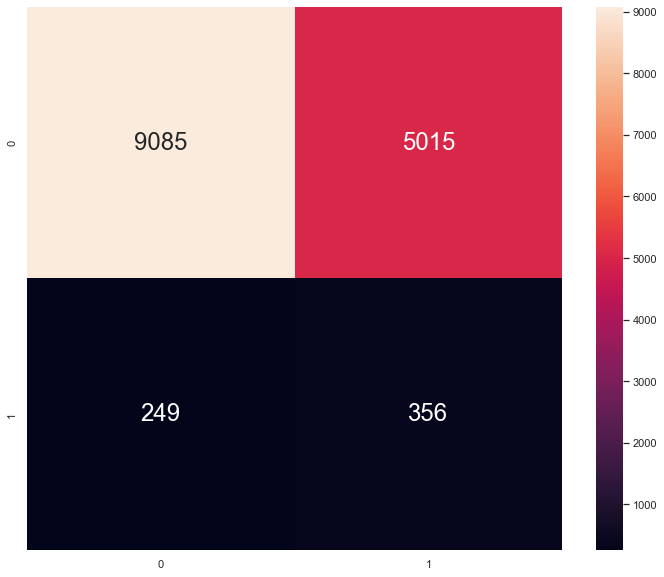

In [121]:
f, axes = plt.subplots(1, figsize=(12, 10))
sb.heatmap(metrics.confusion_matrix(y_test, y_pred_test),
           annot = True, fmt=".0f", annot_kws={"size": 24})

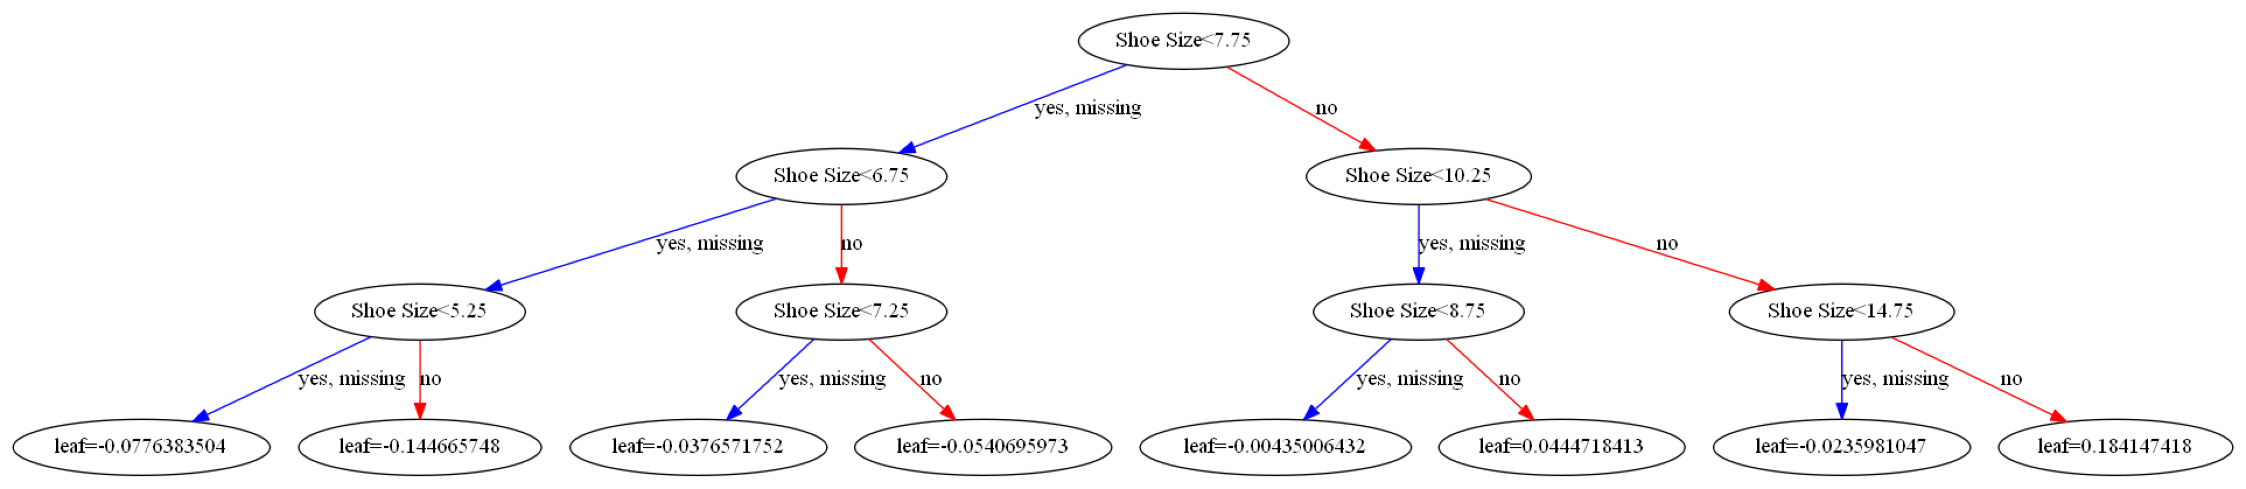

In [125]:
fig, ax = plt.subplots(figsize=(40, 80))
plot_tree(model, num_trees=4, ax=ax)
plt.show()

This tree presents itself as shoe size selling <7.75 as the most important factor in determining the shoe as an outlier.